ChEn-3170: Computational Methods in Chemical Engineering Spring 2024 UMass Lowell; Prof. V. F. de Almeida **25Mar24**

# 10. Shortest Least-Squares Solver
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\yvec}{\boldsymbol{\mathsf{y}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
$

---
## Table of Contents<a id="toc">
  * [Introduction](#intro)
  * [Detailed Algorithm w/ Wrapper Solve Function](#algo)
  * [Test](#test)
    + [Data](#data)
    + [Compute](#compute)
  * [Another Test](#another)
    + [Data](#anotherdata)
    + [Compute](#anothercompute)
---

## [Introduction](#toc)<a id="intro"></a>

Recall course notes OneNote [ChEn-3170-shortest-lsq-solver](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EqrHIQZxGsdKnllQsn2RmvMBlIFaz2TtXan8aldgK6WWuw?e=Z7EnCh) on computational stoichiometry including an introduction to the linear, rank-deficient, least-squares method.

Compute the solution vector $\xvec$ for a given matrix $\Amtrx$ and right-side vector $\bvec$:

\begin{equation*}
\Amtrx\,\xvec= \bvec .
\end{equation*}

When $\Amtrx$ is rank deficient, $\Amtrx^\top\Amtrx$ is also rank deficient (or singular). The normal equations 

\begin{equation*}
\boxed{\Amtrx^\top\Amtrx\,\xvec_\text{LS}  = \Amtrx^\top\,\bvec },
\end{equation*}

*either have an infinite number of solutions or have no solution*. 

Since $\Amtrx$ is rank deficient, a **unique** mininum-norm least squares solution, $\xvec_\text{MNLS}$, exists as follows,

\begin{equation*}
\min\limits_\xvec \Bigl( \norm{\bvec - \Amtrx\,\xvec_\text{MNLS}}^2 +  \lim\limits_{\epsilon\rightarrow 0}\,\epsilon\,\norm{\xvec_\text{MNLS}}^2 \Bigr) \quad\  \forall \quad\ \xvec.
\end{equation*}

This solution is obtained by solving:

\begin{equation*}
\boxed{
\lim\limits_{\epsilon\rightarrow 0}\,\bigl(\Amtrx^\top\Amtrx + \epsilon\Imtrx\bigr) \xvec_\text{MNLS}  = \Amtrx^\top\,\bvec },
\end{equation*}

where $\Amtrx^\top\Amtrx + \epsilon\Imtrx$ is square, symmetric and full rank. This augmented least-squares problem has a unique solution.

## [Detailed Algorithm w/ Wrapper Solve Function](#toc)<a id="algo"></a>
Refer to course Notebooks [08](https://nbviewer.org/github/dpploy/chen-3170/blob/master/notebooks/08-full-rank-least-squares-reaction-rate.ipynb) and [09](https://nbviewer.org/github/dpploy/chen-3170/blob/master/notebooks/09-rank-deficient-least-squares-reaction-rate.ipynb).

In [1]:
'''Wrapper Shortest LS Solve Function'''

import numpy as np

try:    
    from chen_3170.toolkit import solve   
    from chen_3170.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own solve function here. Bailing out.'
    
def shortest_least_squares_solve(a_mtrx, b_vec, epsilon_min=-8, 
                                 pivoting_option='partial', pivot_tol=1e-8, zero_tol=None, verbose=False):
    if verbose:
        np.set_printoptions(precision=3, threshold=100, edgeitems=3, linewidth=100)
        
    epsilon_values = np.logspace(+2,-7,12)
    
    if matrix_rank(a_mtrx) < min(a_mtrx.shape):
        pivot_tol = epsilon_values[-1]
    
    x_norm_history = list() # return to caller
    phi_tilde_history = list() # return to caller

    for epsilon in epsilon_values:

        if verbose:
            print('')
            print('epsilon = %1.1e'%epsilon)
            print('')

        mtrx = a_mtrx.transpose() @ a_mtrx + epsilon * np.eye(a_mtrx.shape[1]) # AT A + epsilon I, AT A is the normal matrix
        vec  = a_mtrx.transpose() @ b_vec                            # AT b

        # Solve (ATA + epsilon I) x = AT b
        x_vec = solve(mtrx, vec, pivoting_option=pivoting_option, pivot_tol=pivot_tol, zero_tol=zero_tol) # matrix is full rank
        #x_vec = np.linalg.solve(mtrx, vec) # if my solver does not work
        
        x_norm = np.linalg.norm(x_vec)
        if verbose:
            print('||x|| = %8.5e'%x_norm)
    
        x_norm_history.append(x_norm) # save for plotting
    
        # test my solution against NumPy solve
        if verbose:
            print('max(abs(x_vec-x_vec_numpy)) = %2.2e'%np.max(np.abs((x_vec - np.linalg.solve(mtrx, vec)))))
    
        if verbose:
            print('')
        
        residual_vec = b_vec - a_mtrx @ x_vec
        phi_tilde_history.append(np.linalg.norm(residual_vec)**2 + epsilon*x_norm**2)

        if verbose:
            print('||b - A x||^2 + eps*||x||^2 = %8.5e'%phi_tilde_history[-1])
            print('||(ATA-epsI)x - ATb||       = %8.5e'%(np.linalg.norm(mtrx@x_vec-a_mtrx.transpose()@b_vec)))
            print('||b - A x|| +       ||x||   = %8.5e'%(np.linalg.norm(residual_vec) + x_norm))
            print('||b - A x||                 = %8.5e'%(np.linalg.norm(residual_vec)))   

    return (x_vec, (epsilon_values, x_norm_history, phi_tilde_history))

## [Test](#toc)<a id="test"></a>

### [Data](#toc)<a id="data"></a>

In [2]:
'''Any A matrix'''

import numpy as np

nrows = 20
ncols = 32

a = -12.2
b =  88.7

set_rank_deficient = True # set to True or False

a_mtrx = (b-a)*np.random.random((nrows,ncols)) + a
a_mtrx /= a_mtrx.max()

if set_rank_deficient:
    if nrows >= ncols:
        a_mtrx[:,-8:] = 0.0
    if nrows < ncols:
        a_mtrx[-8:,:] = 0.0
        
np.set_printoptions(precision=3, threshold=500, edgeitems=4, linewidth=100)
print('A =\n',a_mtrx)

A =
 [[ 0.592  0.644  0.917 -0.082 ...  0.588  0.381  0.136  0.087]
 [ 0.003  0.171  0.555  0.186 ...  0.622  0.76   0.403  0.768]
 [-0.118  0.329  0.389 -0.043 ...  0.403  0.672  0.82   0.916]
 [ 0.108  0.233  0.836  0.864 ...  0.282  0.817  0.819  0.273]
 ...
 [ 0.     0.     0.     0.    ...  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    ...  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    ...  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    ...  0.     0.     0.     0.   ]]


In [3]:
'''Rank of A'''

try:    
    from chen_3170.toolkit import matrix_rank   
except ModuleNotFoundError:
    assert False, 'You need to provide your own matrix_rank function here. Bailing out.'

a_rank = matrix_rank(a_mtrx)
print('S shape   = ',a_mtrx.shape)
print('Rank of S = ',a_rank)

if a_rank == min(a_mtrx.shape):
    print('Matrix is full rank.')
else:
    print('Matrix is rank deficient.')
    
assert a_rank == np.linalg.matrix_rank(a_mtrx)

S shape   =  (20, 32)
Rank of S =  12
Matrix is rank deficient.


In [4]:
'''Any right side vector'''

import numpy as np

a = -40.2
b =  3.7

b_vec = (b-a)*np.random.random(nrows) + a # production rates

np.set_printoptions(precision=3, threshold=100, edgeitems=3, linewidth=100)
print('b_vec =\n',b_vec)

b_vec =
 [ -8.55  -26.48  -35.743  -6.681 -14.815 -19.955 -23.315 -36.757  -1.938  -9.373   1.277  -1.294
  -0.389 -19.563 -10.224  -1.945 -36.214 -26.094 -36.985  -4.97 ]


### [Compute](#toc)<a id="compute"></a>

In [5]:
'''Compute the MNLS solution'''

# use verbose = True for printout
(x_vec, history) = shortest_least_squares_solve(a_mtrx, b_vec, zero_tol=1e-10)

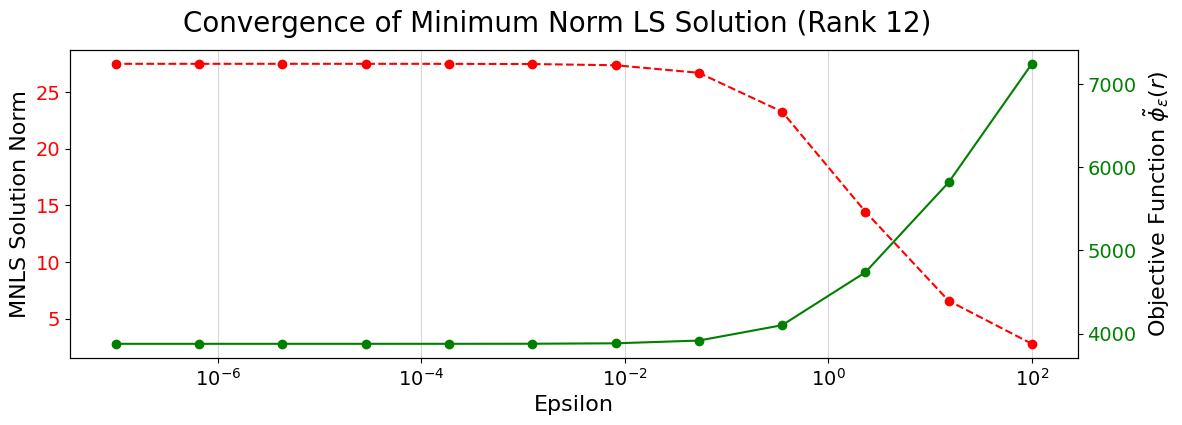

In [6]:
'''Plot Convergence of the Shortest Least-Square Solution Vector'''

(epsilon_hist, x_norm_hist, phi_tilde_hist) = history

from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
#%matplotlib inline
#plt.style.use('dark_background')

(fig, ax1) = plt.subplots(figsize=(13,4))
ax1.semilogx(epsilon_hist, x_norm_hist,'ro--')
ax1.set_ylabel('MNLS Solution Norm',fontsize=16)
ax1.set_xlabel('Epsilon',fontsize=16)
ax1.tick_params(axis='x', labelcolor='black', labelsize=14)
ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
fig.suptitle('Convergence of Minimum Norm LS Solution (Rank %s)'%str(a_rank),fontsize=20)
ax1.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)

ax2 = ax1.twinx()

ax2.semilogx(epsilon_hist, phi_tilde_hist,'go-')
ax2.tick_params(axis='y', labelcolor='green', labelsize=14)
ax2.set_ylabel('Objective Function $\\tilde{\phi}_\epsilon(r)$', fontsize=16)
plt.show()

**NB:** Note that from the previous results, the associated rank-deficient $\Amtrx\xvec=\bvec$ has no solution. The computed $\xvec$ is the shortest LS solution of the modified (*regularized*) LS problem.

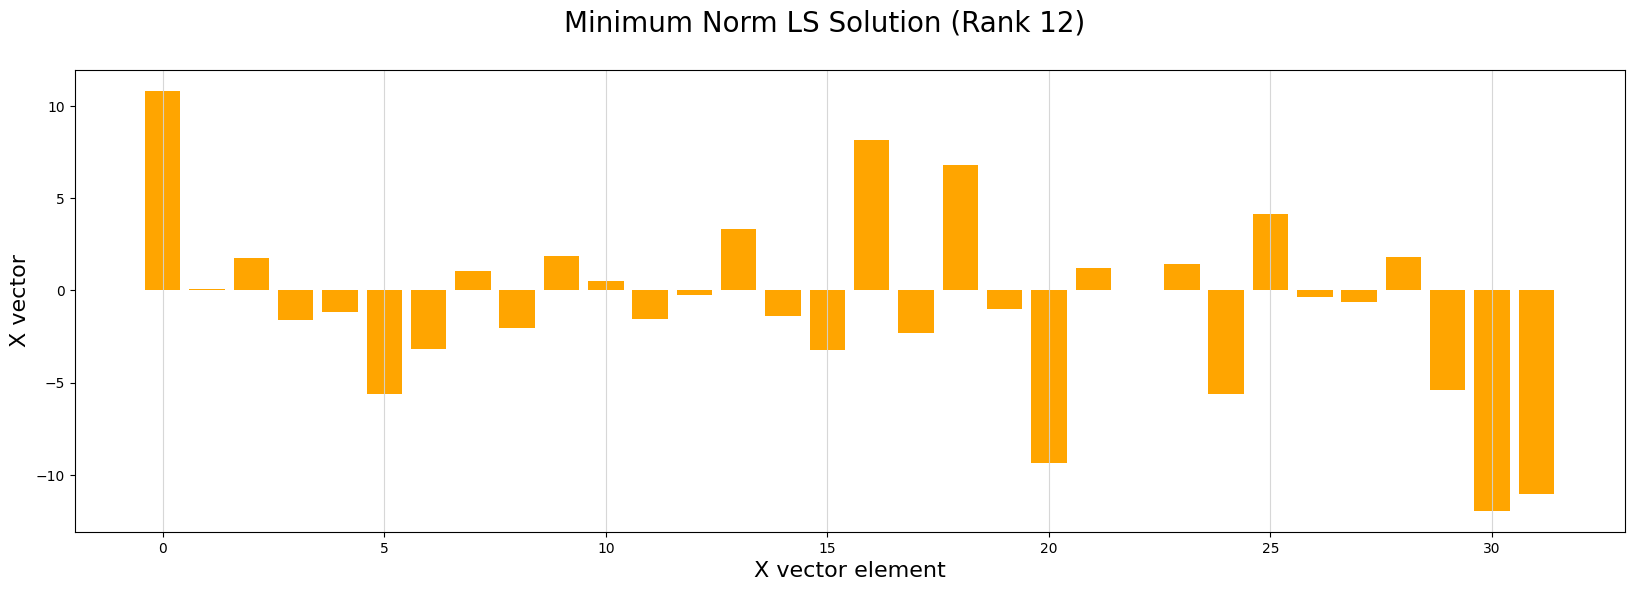

In [7]:
'''Minimum-norm least-squares solution'''

from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
#%matplotlib inline
#plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(20,6))
ax.bar(range(x_vec.size), x_vec, color='orange')

ax.set_ylabel('X vector',fontsize=16)
ax.set_xlabel('X vector element',fontsize=16)
ax.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)
fig.suptitle('Minimum Norm LS Solution (Rank %s)'%str(a_rank),fontsize=20)
plt.show()

## [Another Test](#toc)<a id="another"></a>

Compute the solution vector $\xvec$, given $\Amtrx$ and $\bvec$:

\begin{equation*}
\Amtrx\,\xvec= \bvec .
\end{equation*}

### [Data](#toc)<a id="anotherdata"></a>

In [8]:
'''Any A matrix'''

import numpy as np

nrows = 54
ncols = 28

a = -120.2
b =  808.7

set_rank_deficient = True # set to True or False

a_mtrx = (b-a)*np.random.random((nrows,ncols)) + a
a_mtrx /= a_mtrx.max()

if set_rank_deficient:
    if nrows >= ncols:
        a_mtrx[:,-1] = 0.0
    if nrows < ncols:
        a_mtrx[-1,:] = 0.0
        
np.set_printoptions(precision=3, threshold=100, edgeitems=4, linewidth=100)
print('A =\n',a_mtrx)

A =
 [[ 0.31   0.945 -0.143  0.149 ...  0.462  0.559  0.389  0.   ]
 [ 0.421  0.909  0.181  0.17  ...  0.702  0.967  0.941  0.   ]
 [ 0.882  0.62   0.443  0.235 ...  0.947  0.9    0.596  0.   ]
 [ 0.594  0.684 -0.03   0.55  ...  0.022  0.825  0.489  0.   ]
 ...
 [ 0.776  0.241  0.363  0.093 ...  0.661  0.091  0.557  0.   ]
 [ 0.317  0.426  0.223  0.807 ...  0.19   0.413  0.788  0.   ]
 [ 0.757  0.956  0.697  0.071 ...  0.321  0.202  0.882  0.   ]
 [ 0.246  0.29   0.732  0.751 ...  0.925  0.172  0.3    0.   ]]


In [9]:
'''Rank of A'''

try:    
    from chen_3170.toolkit import matrix_rank   
except ModuleNotFoundError:
    assert False, 'You need to provide your own matrix_rank function here. Bailing out.'

a_rank = matrix_rank(a_mtrx)
print('S shape   = ',a_mtrx.shape)
print('Rank of S = ',a_rank)

if a_rank == min(a_mtrx.shape):
    print('Matrix is full rank.')
else:
    print('Matrix is rank deficient.')
    
assert a_rank == np.linalg.matrix_rank(a_mtrx)

S shape   =  (54, 28)
Rank of S =  27
Matrix is rank deficient.


In [10]:
'''Any right side vector'''

import numpy as np

a = -40.2
b =  3.7

b_vec = (b-a)*np.random.random(nrows) + a # production rates

np.set_printoptions(precision=3, threshold=100, edgeitems=3, linewidth=100)
print('b_vec =\n',b_vec)

b_vec =
 [-13.891 -36.564  -3.931 -22.449  -6.314  -2.991 -18.217 -25.233 -12.748 -24.982 -27.315 -32.373
 -10.216 -10.535 -34.32  -14.246  -7.325  -7.256 -31.459 -21.007  -8.418 -21.647  -3.381 -16.638
 -10.022   1.864  -3.302 -18.545 -22.686   3.474 -40.194  -6.977 -29.035 -35.315 -20.787 -30.343
 -19.368 -14.461  -0.283 -31.12  -17.962  -6.979 -34.11   -7.19  -22.285 -36.673 -34.285   0.682
   2.953 -31.083 -20.115  -0.638 -24.165  -1.991]


### [Compute](#toc)<a id="anothercompute"></a>

In [11]:
# reusing the wrapper solve function
(x_vec, _) = shortest_least_squares_solve(a_mtrx, b_vec)

print('Magnitude of residual vector: ||b - Ax|| = %3.3e'%np.linalg.norm(b_vec-a_mtrx@x_vec))
print('Magnitude of solution vector: ||x|| = %3.3e'%np.linalg.norm(x_vec))

badksub::logical: zero_tol = 2.220446049250313e-15
backsub::logical
 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

AssertionError: not upper triangular matrix; 
 U = 
 array([[ 1.9e+01,  1.1e+01,  7.5e+00,  1.0e+01,  1.1e+01,  9.7e+00,  1.2e+01,  1.2e+01,  1.2e+01,  1.1e+01,  1.3e+01,  7.8e+00,  1.3e+01,  1.0e+01,
         9.3e+00,  1.2e+01,  1.3e+01,  1.3e+01,  1.1e+01,  1.1e+01,  1.1e+01,  1.1e+01,  9.7e+00,  1.4e+01,  1.3e+01,  9.0e+00,  1.1e+01,  0.0e+00],
       [ 0.0e+00,  9.9e+00,  3.6e+00,  3.6e+00,  3.1e+00,  3.1e+00,  2.8e+00,  4.2e+00,  1.7e+00,  2.6e+00,  2.9e+00,  2.9e+00,  2.6e+00,  5.1e+00,
         1.6e+00,  2.3e+00,  5.4e+00,  4.2e+00,  2.9e+00,  5.6e+00,  2.8e+00,  1.9e+00,  5.3e+00,  4.9e+00,  3.9e+00,  5.3e+00,  4.1e+00,  0.0e+00],
       [ 0.0e+00,  4.4e-16,  8.3e+00,  2.7e+00,  4.0e+00,  2.5e+00,  1.6e+00,  3.3e+00,  4.8e+00,  1.6e+00,  3.4e+00,  3.5e+00,  8.5e-01,  2.9e+00,
         2.9e+00,  3.2e+00,  3.9e+00,  2.4e+00,  4.5e+00,  1.9e+00,  1.9e+00,  2.4e+00,  3.8e+00,  1.4e+00,  2.7e+00,  3.3e+00,  5.1e+00,  0.0e+00],
       [-1.8e-15, -1.5e-16,  0.0e+00,  6.9e+00,  1.5e+00, -4.8e-01,  3.5e-01,  1.1e+00,  7.4e-01, -1.3e-01,  1.6e+00,  1.4e-01,  1.8e+00,  1.6e+00,
         2.5e+00,  3.0e-01,  6.3e-01,  2.5e+00,  1.3e+00,  6.6e-01,  3.9e-01,  2.7e-01,  2.1e+00, -1.2e-01,  3.8e-01,  5.9e-01,  1.7e+00,  0.0e+00],
       [ 3.9e-16, -1.8e-16,  0.0e+00,  0.0e+00,  6.3e+00,  1.6e+00,  1.2e+00,  1.9e+00,  1.0e+00,  1.5e+00,  1.2e+00,  1.4e+00,  2.6e+00,  7.2e-01,
         1.1e+00,  9.6e-01,  1.1e+00,  1.1e+00,  1.1e+00,  3.3e-01,  6.7e-01,  2.0e+00,  2.2e+00, -1.8e-01,  5.4e-01,  3.0e-01,  1.2e+00,  0.0e+00],
       [-2.2e-16, -9.8e-17,  0.0e+00,  0.0e+00,  0.0e+00,  6.4e+00,  2.1e+00,  8.5e-01,  1.7e+00,  1.7e+00,  1.5e-01,  1.8e+00,  9.3e-01,  1.8e+00,
         1.1e+00,  5.3e-01,  2.0e+00,  1.8e+00,  7.8e-01,  2.9e-01,  1.9e-01,  5.6e-01,  1.4e+00,  9.0e-01,  1.7e+00,  8.6e-01,  2.1e+00,  0.0e+00],
       [ 8.3e-17, -4.5e-16,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  6.5e+00,  1.2e+00, -3.1e-01, -7.7e-01, -7.7e-01,  4.7e-01,  8.7e-02,  1.2e+00,
         1.0e+00, -5.9e-01, -1.4e-01,  1.7e+00,  4.6e-01,  8.5e-02,  1.7e+00, -1.0e+00,  3.5e-01,  7.2e-01, -8.7e-01,  1.4e-01, -1.1e+00,  0.0e+00],
       [ 1.8e-16, -1.7e-18,  0.0e+00,  0.0e+00, -2.2e-16,  0.0e+00,  0.0e+00,  6.3e+00,  1.2e+00,  1.5e+00, -1.4e+00,  1.9e+00,  3.0e-01,  1.0e+00,
         2.1e+00,  1.2e+00,  3.8e-02, -5.0e-01,  1.2e+00,  1.0e+00,  4.2e-01,  1.2e+00, -9.9e-01,  1.0e+00,  4.8e-01, -8.2e-01,  1.1e+00,  0.0e+00],
       [ 1.6e-16, -2.1e-16,  0.0e+00,  0.0e+00,  4.2e-17, -2.2e-16,  0.0e+00,  0.0e+00,  6.1e+00,  3.9e-01, -4.6e-01,  7.3e-01,  6.5e-01,  9.9e-01,
         5.8e-01,  1.7e-01,  4.7e-01,  2.2e+00,  1.8e+00,  5.3e-03,  5.7e-01,  1.5e+00,  1.3e+00,  6.8e-01,  5.0e-01,  1.0e+00,  7.5e-01,  0.0e+00],
       [-1.1e-16, -5.6e-17,  0.0e+00,  0.0e+00,  5.1e-17,  2.4e-16,  0.0e+00,  0.0e+00,  0.0e+00,  7.7e+00,  3.5e-01,  1.0e+00,  8.4e-01,  1.5e+00,
        -1.7e-01,  1.0e+00,  1.5e+00,  3.3e-01,  1.7e+00,  1.8e-01,  2.6e+00, -1.3e-02,  1.6e+00,  8.3e-01,  1.6e+00,  2.0e+00,  1.4e+00,  0.0e+00],
       [ 4.2e-16,  2.7e-16,  0.0e+00,  0.0e+00, -5.0e-17, -2.8e-17,  0.0e+00,  0.0e+00,  5.6e-17,  0.0e+00,  5.8e+00,  1.0e+00, -4.0e-01, -8.0e-01,
         3.2e-01,  1.4e-01, -5.6e-01,  4.8e-01,  2.6e-01, -2.1e-01, -3.8e-01, -1.5e-03, -3.1e-01, -9.0e-02, -6.7e-01,  1.3e+00,  2.0e-01,  0.0e+00],
       [-1.3e-16, -9.7e-17,  0.0e+00,  0.0e+00,  6.5e-17,  2.1e-19,  0.0e+00,  0.0e+00, -9.9e-18,  0.0e+00,  0.0e+00,  7.3e+00,  5.2e-01,  1.6e+00,
        -5.8e-01,  1.6e+00, -2.8e-01, -9.4e-01,  3.2e+00,  1.5e+00,  1.3e+00,  1.5e+00,  3.5e-01,  1.7e+00,  6.0e-01,  1.7e+00,  1.1e-01,  0.0e+00],
       [ 3.5e-16,  1.4e-16, -1.1e-16,  0.0e+00, -7.6e-18, -1.1e-16,  0.0e+00,  0.0e+00,  4.5e-18,  0.0e+00, -5.6e-17,  0.0e+00,  5.5e+00, -7.7e-01,
        -6.1e-01, -1.4e-01, -7.7e-01, -1.5e-01,  2.9e-02,  3.3e-01,  1.4e+00,  3.0e-01,  3.8e-01,  7.5e-01, -3.7e-01,  4.6e-01, -1.4e+00,  0.0e+00],
       [ 2.3e-15,  1.4e-16, -1.6e-17,  0.0e+00, -3.1e-18, -3.0e-17,  0.0e+00,  0.0e+00,  1.0e-17,  0.0e+00,  1.0e-16,  0.0e+00,  0.0e+00,  4.2e+00,
         4.0e-01,  5.5e-01,  1.6e+00,  8.3e-01,  6.4e-01, -4.5e-01,  1.5e+00, -6.0e-01, -1.2e-01,  1.2e+00, -2.9e-01, -7.0e-03,  1.0e+00,  0.0e+00],
       [ 3.0e-16,  1.2e-17, -1.1e-17,  0.0e+00,  8.0e-17,  1.8e-17,  0.0e+00,  0.0e+00, -4.4e-18,  0.0e+00, -1.6e-17,  0.0e+00,  0.0e+00,  0.0e+00,
         5.2e+00,  1.3e+00, -7.1e-01,  5.3e-01,  7.9e-01, -2.8e-01,  7.1e-01, -1.6e-01,  3.7e-01,  4.6e-01,  2.1e-01,  6.9e-01,  1.1e+00,  0.0e+00],
       [-3.3e-16, -1.6e-16,  2.0e-18,  0.0e+00,  1.1e-16, -2.8e-17,  0.0e+00,  0.0e+00,  7.1e-19,  0.0e+00, -1.1e-17,  0.0e+00,  0.0e+00,  0.0e+00,
         0.0e+00,  4.3e+00, -8.7e-02,  4.5e-01,  4.2e-01,  4.4e-01, -2.1e-01,  6.0e-01, -1.2e+00, -8.9e-01,  2.3e-01,  1.4e-01, -6.9e-01,  0.0e+00],
       [-2.4e-15, -1.3e-16, -1.1e-17,  0.0e+00, -5.8e-19, -3.3e-17,  0.0e+00,  0.0e+00,  5.7e-17,  0.0e+00, -5.0e-17,  0.0e+00, -1.1e-16,  0.0e+00,
         0.0e+00,  0.0e+00,  3.4e+00, -2.1e-01,  7.5e-01, -6.7e-01,  1.8e-01,  6.9e-01,  1.3e-01,  3.2e-01,  4.5e-02,  7.0e-01,  6.9e-01,  0.0e+00],
       [-7.2e-17,  1.3e-16,  2.5e-19,  0.0e+00, -4.2e-17,  7.4e-17,  0.0e+00,  0.0e+00, -3.9e-18,  0.0e+00, -2.2e-17, -1.1e-16, -6.9e-18,  0.0e+00,
         0.0e+00,  0.0e+00,  0.0e+00,  4.3e+00, -3.9e-01,  5.8e-01, -5.2e-03,  1.0e+00,  5.7e-01,  1.7e+00,  5.5e-01, -5.1e-01, -7.7e-01,  0.0e+00],
       [ 2.2e-15, -4.4e-16,  6.9e-18,  0.0e+00, -3.3e-17,  3.5e-17,  0.0e+00,  0.0e+00, -1.2e-17,  0.0e+00, -3.0e-18, -1.0e-17,  2.7e-17,  0.0e+00,
         0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  4.2e+00,  5.2e-01,  3.9e-01,  8.3e-01,  1.0e+00, -1.6e-01,  5.0e-01,  1.2e+00, -1.4e-01,  0.0e+00],
       [-2.8e-16, -8.9e-16,  1.1e-18,  0.0e+00,  2.3e-17, -2.0e-17,  0.0e+00,  0.0e+00,  1.8e-17,  0.0e+00,  8.1e-18,  1.6e-17, -2.4e-17,  0.0e+00,
         0.0e+00, -5.6e-17,  0.0e+00, -1.1e-16,  0.0e+00,  4.5e+00, -6.9e-01,  3.5e-01,  5.3e-02, -2.0e-01, -2.5e-01, -1.3e+00,  1.3e+00,  0.0e+00],
       [ 8.2e-16, -5.8e-17,  3.6e-17,  0.0e+00, -1.7e-17, -2.8e-17,  0.0e+00,  0.0e+00,  2.0e-18,  0.0e+00, -1.5e-17,  3.3e-18, -4.7e-19,  0.0e+00,
         0.0e+00, -8.5e-18,  0.0e+00, -1.7e-17,  0.0e+00,  0.0e+00,  4.2e+00, -6.1e-01,  5.3e-01, -3.0e-01, -4.2e-01,  2.8e-01, -5.7e-01,  0.0e+00],
       [ 5.0e-16,  1.2e-16,  9.2e-18,  0.0e+00,  1.6e-17,  4.2e-17,  0.0e+00,  0.0e+00, -6.1e-18,  0.0e+00,  3.2e-17,  2.8e-17,  2.0e-17,  0.0e+00,
         0.0e+00,  3.1e-18,  0.0e+00,  6.2e-18,  0.0e+00,  0.0e+00,  0.0e+00,  4.4e+00,  1.1e+00,  7.1e-01,  4.6e-01,  9.1e-03,  5.5e-01,  0.0e+00],
       [-2.1e-16,  5.5e-17,  4.7e-19,  0.0e+00, -2.3e-17, -2.8e-17,  0.0e+00,  1.1e-16,  6.1e-18,  0.0e+00,  4.2e-18,  9.5e-18, -6.1e-18,  0.0e+00,
         0.0e+00,  9.5e-19,  0.0e+00,  1.9e-18,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  4.7e+00, -1.3e-01, -1.0e+00,  8.4e-01, -5.3e-01,  0.0e+00],
       [-4.8e-16, -1.7e-16,  2.3e-17, -1.4e-17,  4.0e-17, -2.0e-17,  0.0e+00,  3.1e-18, -2.0e-18,  0.0e+00, -1.4e-17,  4.1e-17,  1.2e-16,  0.0e+00,
        -5.6e-17, -3.6e-18,  0.0e+00, -7.1e-18,  2.8e-17,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  4.6e+00,  5.1e-02,  6.5e-01,  7.9e-01,  0.0e+00],
       [ 1.3e-16, -8.0e-17, -6.5e-18,  1.5e-19, -1.6e-17, -7.0e-17,  0.0e+00, -3.2e-17,  1.3e-17,  0.0e+00,  4.9e-18,  1.5e-17,  4.9e-17,  0.0e+00,
         6.1e-19, -4.0e-18,  0.0e+00, -8.0e-18, -3.0e-19,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  4.3e+00,  8.3e-02,  4.8e-01,  0.0e+00],
       [-1.1e-16,  6.9e-16,  5.8e-18,  1.9e-18, -5.6e-17,  7.0e-19,  0.0e+00, -2.0e-17, -1.4e-17,  0.0e+00,  2.0e-17, -1.4e-17, -9.7e-18,  0.0e+00,
         7.8e-18, -1.5e-17,  0.0e+00, -3.0e-17, -3.9e-18,  0.0e+00,  0.0e+00,  0.0e+00,  1.1e-16,  1.1e-16,  0.0e+00,  3.4e+00,  1.3e-01,  0.0e+00],
       [ 5.6e-16,  3.9e-17, -2.0e-17, -2.2e-16,  4.7e-19, -2.0e-17,  0.0e+00,  1.6e-17, -1.8e-17,  0.0e+00, -3.8e-17, -3.5e-17, -1.5e-19,  0.0e+00,
         9.1e-18,  1.6e-17,  0.0e+00,  3.2e-17, -4.6e-18,  2.2e-16,  0.0e+00,  0.0e+00, -4.2e-18, -4.2e-18,  0.0e+00,  0.0e+00,  2.7e+00,  0.0e+00],
       [ 0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,
         0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  3.5e-01]])

In [ ]:
# using an external solve function
try:    
    from chen_3170.toolkit import shortest_least_squares_solve   
except ModuleNotFoundError:
    assert False, 'You need to provide your own lu_factorization function here. Bailing out.'

x_vec = shortest_least_squares_solve(a_mtrx, b_vec, zero_tol=1e-10)

print('Magnitude of residual vector: ||b - Ax|| = %3.3e'%np.linalg.norm(b_vec-a_mtrx@x_vec))
print('Magnitude of solution vector: ||x|| = %3.3e'%np.linalg.norm(x_vec))

In [ ]:
'''Minimum norm least-squares solution'''

from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
#%matplotlib inline
#plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(20,6))
ax.bar(range(x_vec.size), x_vec, color='orange')

ax.set_ylabel('X vector',fontsize=16)
ax.set_xlabel('X vector element',fontsize=16)
ax.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)
fig.suptitle('Minimum Norm LS Solution (Rank %s)'%str(a_rank),fontsize=20)
plt.show()